# Приоритезация гипотез и анализ результатов А/В теста 

## Введение

Цель - провести анализ данных от отдела маркетинга, запустить А/В тест и проанализировать его результаты, составить рекомендации.

План

*Выгрузить и провести предобработку данных*


*Провечти приоритезацию гипотез*
- Использовать фреймворки ICE и RICE


*Провести анализ A/B-теста*



*Вывод*
- Описать рекомендации

## Выгрузка и предобработка данных

### Выгрузка данных

In [1]:
# выгружу необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import scipy.stats as stats
import warnings

from scipy import stats as st

In [2]:
pd.set_option('display.max_colwidth', False)

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')




In [4]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [6]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


### Обзор  данных

In [7]:
hypothesis.info() #изучу общую информацю hypothesis

orders.info() #изучу общую информацю orders

visitors.info() #изучу общую информацю visitors

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

In [8]:
#проверю на дубликаты hypothesis
print('Дубликаты', hypothesis.duplicated().sum())
print('Пропуски', hypothesis.isna().sum())



Дубликаты 0
Пропуски Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64


In [9]:
#проверю на дубликаты и пропуски orders
print('Дубликаты', orders.duplicated().sum())
print('Пропуски', orders.isna().sum())

Дубликаты 0
Пропуски transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


In [10]:
#проверю на дубликаты и пропуски visitors
print('Дубликаты', visitors.duplicated().sum())
print('Пропуски', visitors.isna().sum())

Дубликаты 0
Пропуски date        0
group       0
visitors    0
dtype: int64


Пропусков и дубликатов в данных нет. 

### Предобработка данных

#### Предобработка hypothesis

In [11]:
#приведу названия стобцов hypothesis к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.head()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


#### Предобработка orders

In [12]:
orders.columns.to_list()

['transactionId', 'visitorId', 'date', 'revenue', 'group']

In [13]:
#изменю названия стобцов orders
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [14]:
# изменю тип данных для столбцов, которые содержат даты
orders['date'] = pd.to_datetime(orders['date'])

In [15]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


#### Предобработка  visitors

In [16]:
# изменю тип данных для столбцов, которые содержат даты
visitors['date'] = pd.to_datetime(visitors['date'])


In [17]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Провела предобработку данных:
- привела названия столбцов к "хорошему тону"
- изменила типы данных в стобцах с датами

In [18]:
#дата начала и конца теста
print('начало теста', min(orders['date']))
print('конец теста', max(orders['date']))

начало теста 2019-08-01 00:00:00
конец теста 2019-08-31 00:00:00


In [19]:
#посомтрю, какие группы есть в тесте
groupss = orders['group'].unique()
print(groupss)


['B' 'A']


In [20]:
#посмотрю, сколько юзеров в каждой группе
visitors_a = visitors.query('group == "A"')['visitors'].sum()
visitors_b = visitors.query('group == "B"')['visitors'].sum()

group_dif = ((abs(1-(visitors_a/visitors_b)))*100).round(2)
print('Количество посетителей в группе А:', visitors_a)
print('Количество посетителей в группе В:', visitors_b)
print(f'Отличие между кол-вом посетителей в групах {group_dif} %')


Количество посетителей в группе А: 18736
Количество посетителей в группе В: 18916
Отличие между кол-вом посетителей в групах 0.95 %


Группа А отличается от группы B менее чем на прцент.

In [21]:
#поищу одних и тех же юзеров в разных группах

users_a = orders[orders.group == 'A']['visitor_id'].unique()
users_b = orders[orders.group == 'B']['visitor_id'].unique()
how_m_users = list(set(users_a)&set(users_b))
print(len(how_m_users))

58


Обнаружилось 58 юзеров, которые оказались в двух группах теста одновременно. Возможно изначально некорректно был настроен траффик или какие-то еще процессы. Тест проведен некорректно.

В данном тесте я не буду исключать этих пользователей, так как скорее всего они зацепили и таблицу visitors, а в ней нет id и я их не найду и не смогу удалить. 

Если говорить о цифрах, то 58 пользователей составляют менее 0,5% и не должны повлиятт на дальнейшийанализ

## Приоритезация гипотез

Приоритезирую гипотезы, которые предоставил отдел маркетинга с помощью фреймворка ICE. Отсортирую по убыванию приоритета

In [22]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


На данном этапе можно выделить топ-3 гипотез:
- 8 Запустить акцию, дающую скидку на товар в день рождения
- 0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- 7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

Посмотрю с помощью  фреймворка RICE. Отсортирую по убыванию приоритета.

In [23]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


По фреймворку RICE в топ-3 вошли следующие гипотезы
- 7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- 2 Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	
- 0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Посмотрю, как изменилась приоритизация гипотез при применении RICE вместо ICE. 

In [24]:
hypothesis[['hypothesis','ice', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.0


При применении фреймворка  RICE вместо ICE:
- гипотеза 7 поднялась с 3 места на 1
- гипотеза 0 опустилась со 2 на 3 место
- гипотеза 2 поднялась с 5 места на 2 
- гипотеза 8 опустилась с 1 на 5

Фреймворк RICE учитывает охват пользователей, которых коснется изменение, поэтому гипотезы, которые касаются большего количества пользователей более приоритетны.

Вывод:

Выбор в пользу определенной гипотезы необходимо прнимать, учитывая основные цели и риски.

По методике, ICE (не учитывает при ранжировании охват юзеров) рекомендую обратить внимание на следующие гипотезы:

- 8 Запустить акцию, дающую скидку на товар в день рождения
- 0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- 7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок





По методике, RICE (учитывает при ранжировании охват юзеров) рекомендую обратить внимание на следующие гипотезы:

- 7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- 2 Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- 0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

## Анализ A/B-теста

#### График кумулятивной выручки по группам. 

Сделайте выводы и предположения

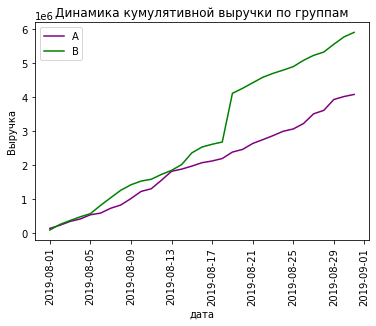

In [25]:
dates_grouped = orders[['date', 'group']].drop_duplicates()

orders_grouped = dates_grouped.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

orders_grouped.head(6)

visitors_grouped = dates_grouped.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max', 
            'group': 'max', 
            'visitors': 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_grouped.head(6)

cumulative_data = orders_grouped.merge(
    visitors_grouped, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data.head(6)

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

#график кумулятивной выручки по группам
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'],color='purple', label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'],color='green', label='B')
plt.title('Динамика кумулятивной выручки по группам')
plt.ylabel('Выручка')
plt.xticks(rotation=90)
plt.xlabel('дата')

plt.legend()
plt.show()

- График выручки ггруппы В плавно растет до примерно 20.08, 21.08 происходит резкий скачок графика и дальнейший рост.
- График выручки группы А растет плавно и линейно, без скачков.
- Исходя из графиков выручка В больше А

#### График кумулятивного среднего чека по группам

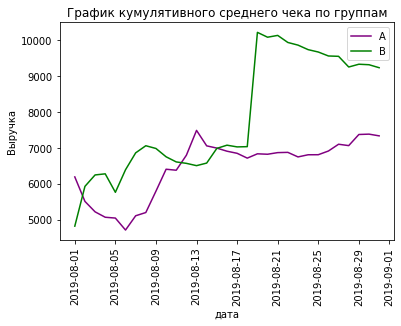

In [26]:
#график А
plt.plot(cumulative_revenue_a['date'],cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'], color='purple', label='A')
#график В
plt.plot(cumulative_revenue_b['date'],cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], color='green',label='B')

plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Выручка')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('дата')
plt.show()

- В начале теста средний чек в группе А падает до примерно 6.08. Коснувшись низшей точки,средний чек в группе  А начинает расти до 13.08 и далее плавно стабилищируется.
- Средний чек в группе В растет волнообразно примерно до 18.08, далее резкий рост примерно до 20.08 и плавное линейное снижение. Возможно в группу В попал очень большой заказ в даты резкого роста. Которые, кстати, совпадают с датами роста на графике выручки по группе В

#### График относительного изменения кумулятивного среднего чека группы B к группе A.

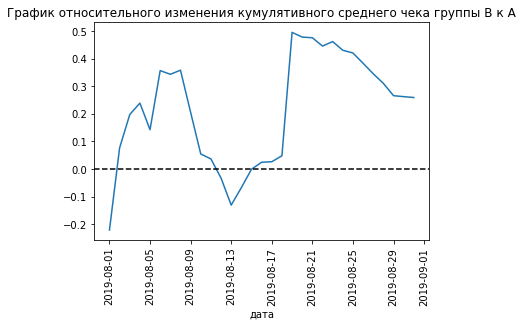

In [27]:
# собираем данные в одном датафрейме
cumulative_revenue_ab = cumulative_revenue_a.merge(
    cumulative_revenue_b, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_a', '_b']
)

# cтроим отношение средних чеков
plt.plot(cumulative_revenue_ab['date'],(cumulative_revenue_ab['revenue_b']/cumulative_revenue_ab['orders_b'])/(cumulative_revenue_ab['revenue_a']/cumulative_revenue_ab['orders_a'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к A')
plt.xticks(rotation=90)
plt.xlabel('дата')
plt.ylabel('')
plt.show()

- График имеет резкие скачки в нескольких точках: примерно 4.08, 8-9.08, примерно 20.08.
- Есть несколько резких падений графика: после 5.08, 13.08.
- Плавное снижение после 20.08

Это может говорить о каких-то крупных заказа эти данные или других аномальных вещах

#### График кумулятивного среднего количества заказов на посетителя по группам. 

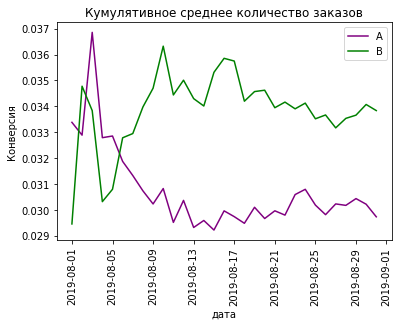

In [28]:
# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], color='purple', label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], color='green', label='B')
plt.legend()
plt.title('Кумулятивное среднее количество заказов')
plt.xlabel('дата')
plt.ylabel('Конверсия')
plt.xticks(rotation=90)
plt.show()

- В обеих группах в начале теста с 1.08 по 5.08 графики резко колеблются.
- После 5.08 конверсия в группе В резко растет примерно до 10.08, фиксируется примерно в одном диапазоне с тенденцией к плавному снижению.
- Конверсия в группе А резко падает примерно с 3.08, с 8.09 фиксируется и продолжает падать на всем таймлайне.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

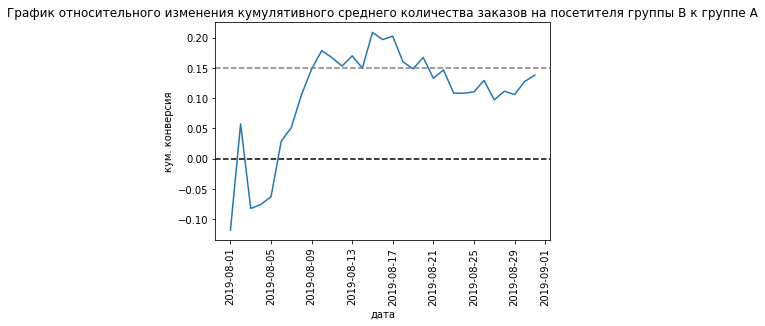

In [29]:
cumulative_conversions_ab = (cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']],left_on='date',right_on='date',how='left',suffixes=['_a', '_b']))

plt.plot(cumulative_conversions_ab['date'],cumulative_conversions_ab['conversion_b']/cumulative_conversions_ab['conversion_a']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xticks(rotation=90)
plt.xlabel('дата')
plt.ylabel('кум. конверсия')
plt.show()

- Группа В до 5.08 показывала результат ниже группы А
- С 5.08 группа В показывает рост
- Примерно с 20.08 кумулятивная конверсия группы В плавно снижается до 29.08

Нужно посмотреть аномалии, которые выделялись и напрошлых графиках.


#### Точечный график количества заказов по пользователям.

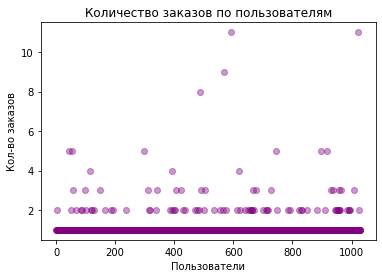

In [30]:
orders_by_users = (orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'}))
orders_by_users.columns =  ['visitor_id', 'orders']

x_values = pd.Series(range(0,len(orders_by_users)))

#точечная диаграмма
plt.scatter(x_values, orders_by_users['orders'], color='purple', alpha=0.4)
plt.title('Количество заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Кол-во заказов')
plt.show()

- Большая часть пользователей совершает 1 заказ.
- Есть пользователи, которые совершили от 2 до 6 заказов, на графике их точек довольно большое количество.
- Есть пользователи, которые совершили более 8 заказов - их меньшее количество

#### 95-й и 99-й перцентили количества заказов на пользователя. 

Чтобы определить грань, где начинаются аномальные данные посчитаю  95-й и 99-й перцентили количества заказов на пользователя.

In [31]:
np.percentile(orders_by_users['orders'], [95, 99])


array([2., 4.])

- 1% пользователей совершил 4 и более заказов во время теста.
- не больше 5% пользователей совершали больше 2 заказов

Отсеку далее количество заказов свыше 4

#### Точечный график стоимостей заказов

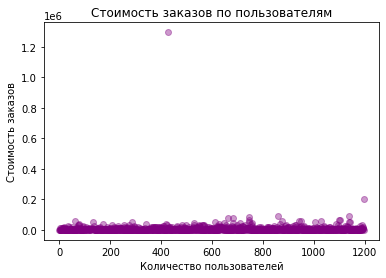

In [32]:
x_values = pd.Series(range(0,len(orders['revenue'])))

#точечная диаграмма
plt.scatter(x_values, orders['revenue'], color='purple', alpha=0.4)
plt.title('Cтоимость заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов')
plt.show()


- Один из заказов улетел в космос и его стоимость превышает 1,2 и искажает график
- Большая часть распределена в диапазоне до 0,1

#### 95-й и 99-й перцентили стоимости заказов

Чтобы определить грань, где начинаются аномальные данные посчитаю  95-й и 99-й перцентили стоимости заказов на пользователя.

- Не более 5% заказов дороже 28 000
- Не более 1% заказов дороже 58 233

Отсеку суммы заказов, превыщающие 99 ый перцентили. 

#### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Расчитаю статистическую значимость различий в конверсии между группами по «сырым» данным. На данном этапе не буду удалять выбросы, которые обнаружила выше.

Гипотезы:

- Но: конверсия между группами не отличается
- Н1: конверсия между группами отличается
 
- Уровень значимости:alpha = 0.05 


Буду использовать проверку критерием Манна-Уитни, так как  работа с самими значениями невозможна из-за выбросов, сильно сдвигающих параметрические результаты.


In [33]:
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_cummulative_a = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_a.columns = ['date', 'visitors_cummulative_a']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

visitors_cummulative_b = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_b.columns = ['date', 'visitors_cummulative_b']

orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_a.columns = ['date', 'orders_daily_a', 'revenue_per_date_a']

orders_cummulative_a = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_a.columns = ['date','orders_cummulative_a','revenue_cummulative_a']

orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_b.columns = ['date', 'orders_daily_b', 'revenue_per_date_b']

orders_cummulative_b = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_b.columns = ['date','orders_cummulative_b','revenue_cummulative_b']


data = (
    orders_daily_a.merge(
        orders_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_b, left_on='date', right_on='date', how='left')
)


In [34]:
 #переменная группыА
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

#переменная группы В
orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']


In [35]:
#переменная sample_a
sample_a = pd.concat([orders_by_users_a['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitors_per_date_a'].sum() - 
                                          len(orders_by_users_a['orders'])), 
                          name='orders')],axis=0
                    )

# переменная sample_b
sample_b = pd.concat([orders_by_users_b['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitors_per_date_b'].sum() - 
                                          len(orders_by_users_b['orders'])), 
                          name='orders')],axis=0
                    )

In [36]:
# Функция для проверки гипотезы о равенстве групп data A и data B
def statistic_sign(data_a, data_b):
    alpha = 0.05
    p_value = stats.mannwhitneyu(data_a, data_b)[1]
    print("P-value: {0:.5f}".format(p_value))

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: есть основания считать, что есть отличия")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что есть отличия")
    
    print("Прирост В к А: {0:.5%}".format(data_b.mean() / data_a.mean()-1))

In [37]:
statistic_sign(sample_a, sample_b)

P-value: 0.01679
Отвергаем нулевую гипотезу: есть основания считать, что есть отличия
Прирост В к А: 13.80788%



- Отвергаем нулевую гипотезу " Но: конверсия между группами не отличается", так как p-value 0.01679 < 0.05
- По "сырым" данным отличия между конверсиями групп А и В есть.
- Относительный выйгрыш группы B равен 13,8 %

#### Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным. 

Аналогично рассчитаю статистическую значимость различий в среднем чеке между группами по «сырым» данным.

Гипотезы:

- Но: средний чек  между группами не отличается

- Н1: средний чек между группами отличается
 

Уровень значимости:alpha = 0.05



In [38]:
statistic_sign(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])


P-value: 0.72929
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что есть отличия
Прирост В к А: 25.87137%


- Не отвергаем Но, p-value 0.72929 > 0.05
- По сырым данным нет оснований считать, что отличия между средними чеками есть 
- Относительный выйгрыш группы B равен 25.9 %

#### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Выше я рассчитывала перцентили стоимости заказов и перцентили количества заказов на пользователя.
Для дальнейшего расчета я отсеку по 1% пользователей со стоимостью заказов выше 58233 и 1% пользователей с количеством заказов выше 4  

Продублирую гипотезы:
- Но: конверсия между группами не отличается
- Н1: конверсия между группами отличается

In [39]:
#много заказов
too_much_orders = np.percentile(orders_by_users['orders'], 99)
#самые дорогие заказы
so_exp_orders = np.percentile(orders['revenue'], 99)

#"выделяющиеся" юзеры заказали > 99 percentile
users_with_too_much_orders = pd.concat([orders_by_users_a[orders_by_users_a['orders'] > too_much_orders]['visitor_id'],orders_by_users_b[orders_by_users_b['orders'] > too_much_orders]['visitor_id'],],axis=0,)

#"выделяющиеся" юзеры заплатили > 99 percentile
users_with_so_exp_orders = orders[orders['revenue'] > so_exp_orders]['visitor_id']


n_users = (pd.concat([users_with_too_much_orders, users_with_so_exp_orders], axis=0).drop_duplicates().sort_values())
display(n_users.head(5))
n_users.shape[0]

1099    148427295 
949     887908475 
744     888512513 
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64

15

15 "выдающихся" аномальных юзеров. 
Далее посмотрю, повлияли ли их действия на результаты теста: расчитаю статистическую значимость различий в среднем количестве заказов по посетителям между группами теста по "чистым" данным.

In [40]:
#подготовлю выборки количества заказов по пользователям по группам теста
sample_a_filter = pd.concat([orders_by_users_a[np.logical_not(orders_by_users_a['visitor_id'].isin(n_users))]['orders'],pd.Series(0,index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])),name='orders',),],axis=0,)

sample_b_filter = pd.concat([orders_by_users_b[np.logical_not(orders_by_users_b['visitor_id'].isin(n_users))]['orders'],pd.Series(0,index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])),name='orders',),],axis=0,)

In [41]:
statistic_sign(sample_a_filter, sample_b_filter)

P-value: 0.01438
Отвергаем нулевую гипотезу: есть основания считать, что есть отличия
Прирост В к А: 15.33131%


- Отвергаем Но, p-value 0.01438 > 0.05
- По "чистым" данным есть основание считать, что отличия между средним количеством заказов на пользователя есть. 
- Относительный выйгрыш группы B равен 15.3 %

#### Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.  

Посмотрю, повлияли ли действия "выдающихся" юзеров на результаты теста: расчитаю статистическую значимость различий среднем чеке заказа между группами по «очищенным» данным.

Продублирую гипотезы:

- Но: средний чек  между группами не отличается

- Н1: средний чек между группами отличается

In [42]:
statistic_sign(orders[(orders['group']=='A') & np.logical_not(orders['visitor_id'].isin(n_users))]['revenue'],orders[(orders['group']=='B') & np.logical_not(orders['visitor_id'].isin(n_users))]['revenue'])

P-value: 0.85091
Не получилось отвергнуть нулевую гипотезу, нет оснований считать, что есть отличия
Прирост В к А: -0.57489%


- Но отвергнуть не вышло, p-value 0.85091 > 0.05
- По "чистым" данным нет оснований считать, что средний чек между группами отличается. 


## Вывод

#### Рекомендации по тесту

Остановить тест, зафиксировать победу группы В. 
- И по "сырым" данным и по "чистым" есть основание считать, что отличия между средним количеством заказов на пользователя есть.
- Относительный выйгрыш группы B равен 15.3 % по "чистым данным.
- Нет оснований считать, что средний чек между группами отличается ни по "сырым", ни по "чистым" данным

Я провела анализ данных, предоставленных интернет-магазином.
Совместно с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Я приоритизировали гипотезы, используя фреймворки ICE и RICE
Запустила A/B-тест и проанализировала результаты, на основании которых подготовила рекомендацию остановаить тест, зафиксировав победу группы Б